In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sbs import SBS

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
print('Class labels:', np.unique(df_wine['Class label']))

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Class labels: [1 2 3]


## Regularization using weight penalty

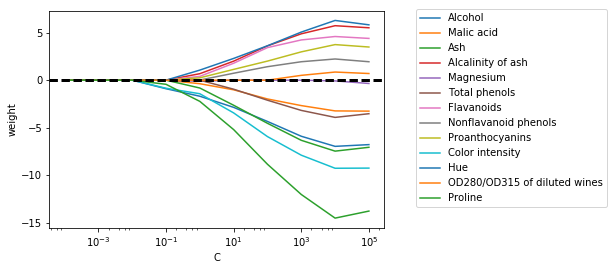

In [57]:
fig = plt.figure()
ax = plt.subplot()

weights = []
reg_terms = []

for c in range(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    reg_terms.append(10**c)
    
weights = np.array(weights)

for column in range(weights.shape[1]):
    plt.plot(reg_terms, weights[:, column], label=df_wine.columns[column + 1])

plt.ylabel('weight')
plt.xlabel('C')
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xscale('log')
plt.legend()
ax.legend(loc='upper center',
            bbox_to_anchor=(1.38, 1.03),
            ncol=1, fancybox=True)
plt.show()

## Feature selection via SBS

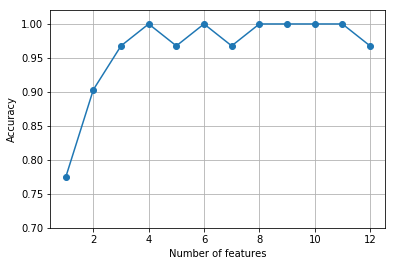

In [28]:
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')

plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')

plt.grid()

plt.show()

In [29]:
k3 = list(sbs.subsets_[-3])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Total phenols', 'Color intensity'], dtype='object')


In [33]:
knn.fit(X_train_std, y_train)
print('All train accuracy:', knn.score(X_train_std, y_train))
print('All test accuracy:', knn.score(X_test_std, y_test))

knn.fit(X_train_std[:, k3], y_train)
print('Three best train accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Three best test accuracy:', knn.score(X_test_std[:, k3], y_test))

All train accuracy: 0.959677419355
All test accuracy: 0.925925925926
Three best train accuracy: 0.935483870968
Three best test accuracy: 0.888888888889


## Feature selection using random forests

  1.) Proline                        0.17992693779934765
  2.) Color intensity                0.15315770609184445
  3.) Flavanoids                     0.1461228680689352
  4.) Alcohol                        0.13822434128388697
  5.) OD280/OD315 of diluted wines   0.11481799554990071
  6.) Hue                            0.07752497212441116
  7.) Total phenols                  0.058235657900474
  8.) Malic acid                     0.030855737083571692
  9.) Alcalinity of ash              0.029999800792012216
 10.) Proanthocyanins                0.025713395711502676
 11.) Magnesium                      0.02513494158344363
 12.) Nonflavanoid phenols           0.01154759419581525
 13.) Ash                            0.008738051814854037


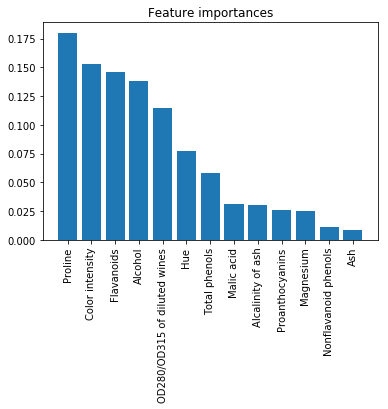

In [73]:
feature_names = df_wine.columns[1:]
columns = range(X_train.shape[1])

forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indeces = np.argsort(importances)[::-1]

for col in columns:
    # print(col+1, feature_names[col], importances[indeces[col]])
    print('{:3}.) {:<30} {}'.format(col+1, feature_names[indeces[col]], importances[indeces[col]]))
    
plt.title('Feature importances')

plt.bar(columns, importances[indeces])
plt.xticks(columns, feature_names[indeces], rotation=90)
plt.show()

## Feature selection using from model

In [78]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)

X_selected = sfm.transform(X_train)

print('Number of samples that meet this criterion:', X_selected.shape[0])

for col in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (col + 1, 30, feature_names[indeces[col]], importances[indeces[col]]))

Number of samples that meet this criterion: 124
 1) Proline                        0.179927
 2) Color intensity                0.153158
 3) Flavanoids                     0.146123
 4) Alcohol                        0.138224
 5) OD280/OD315 of diluted wines   0.114818
